In [39]:
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 5

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


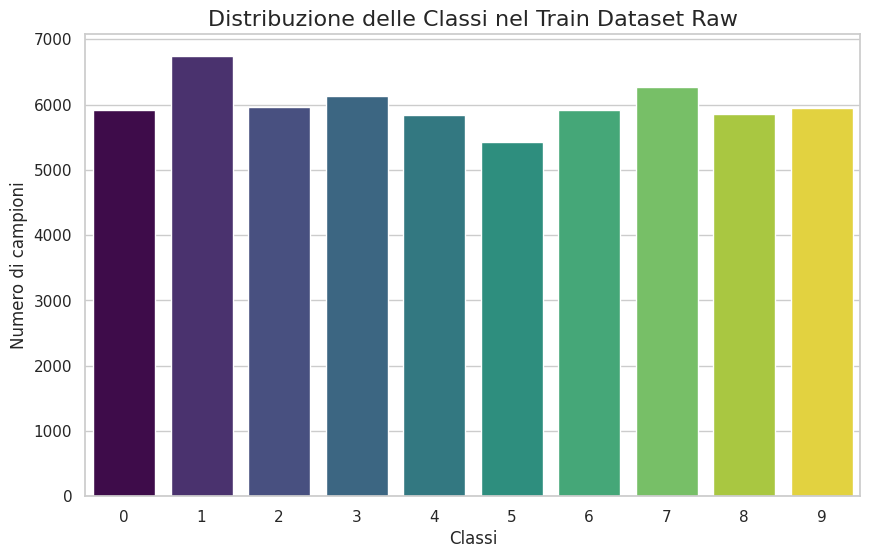

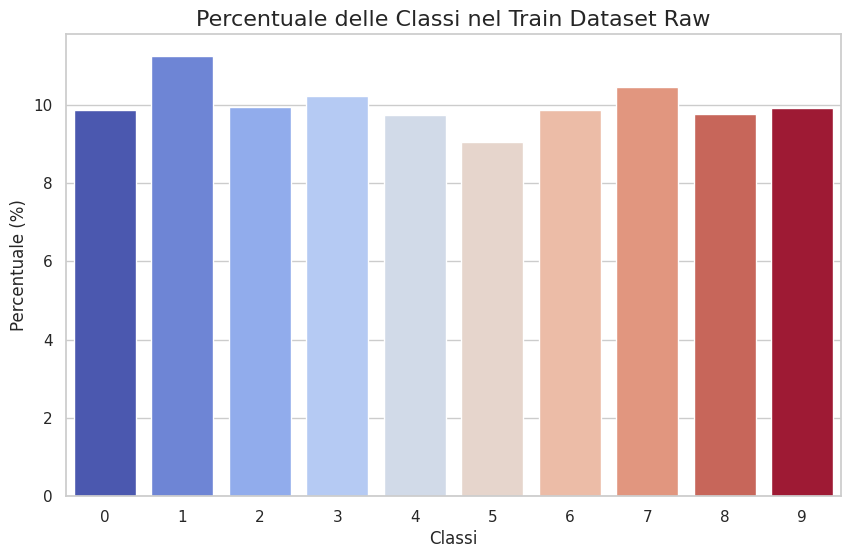

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




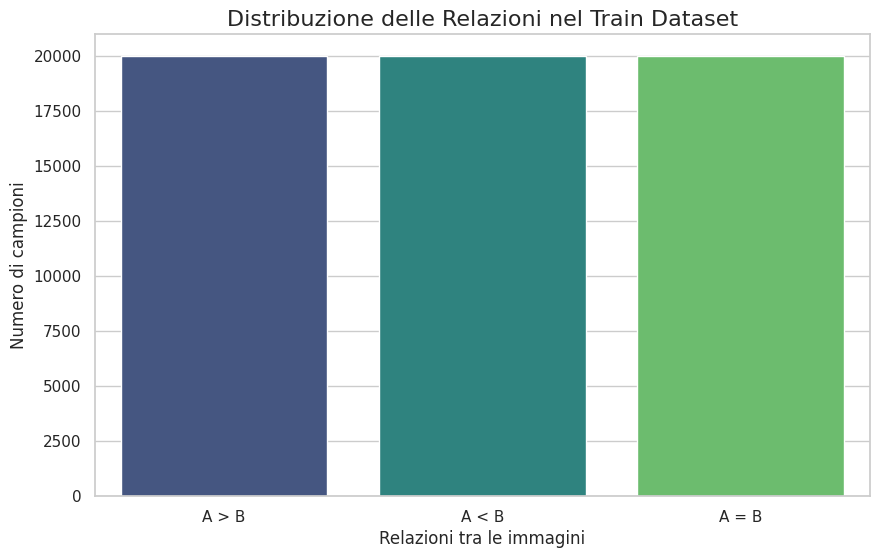

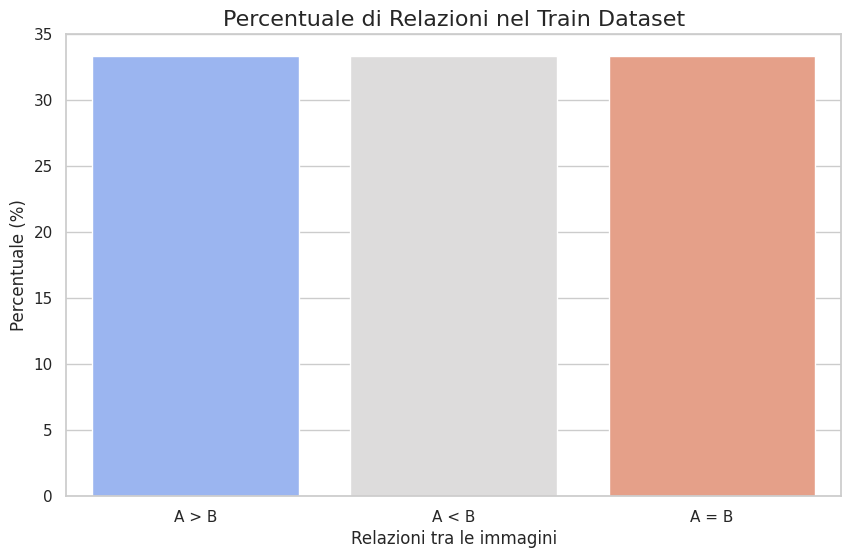

In [4]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 990, 2: 1021, 0: 989}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 1: 990 campioni (33.00%)
Relazione 2: 1021 campioni (34.03%)
Relazione 0: 989 campioni (32.97%)




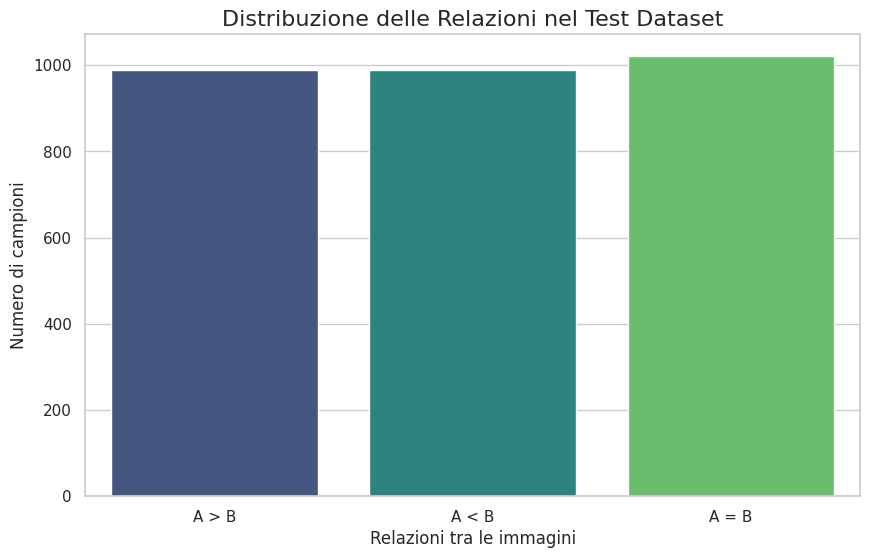

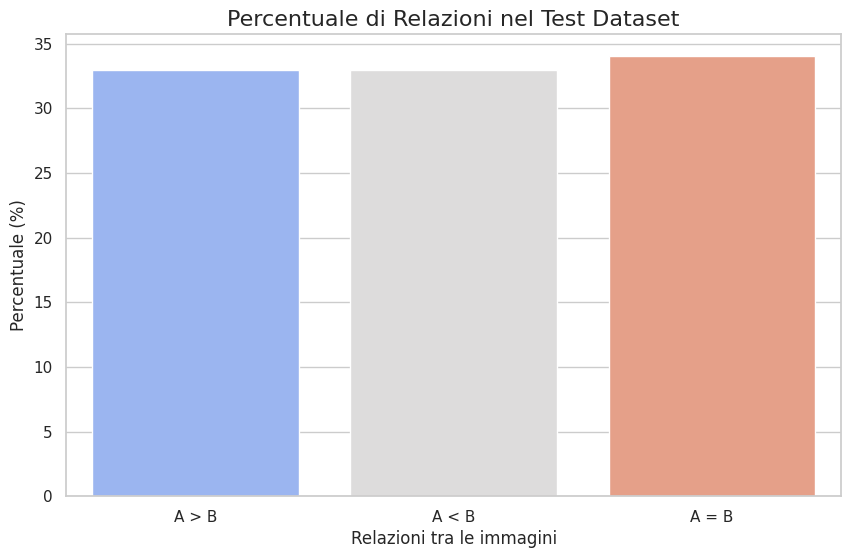

In [5]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2344, 1: 2343, 2: 2312}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2344 campioni (33.49%)
Relazione 1: 2343 campioni (33.48%)
Relazione 2: 2312 campioni (33.03%)




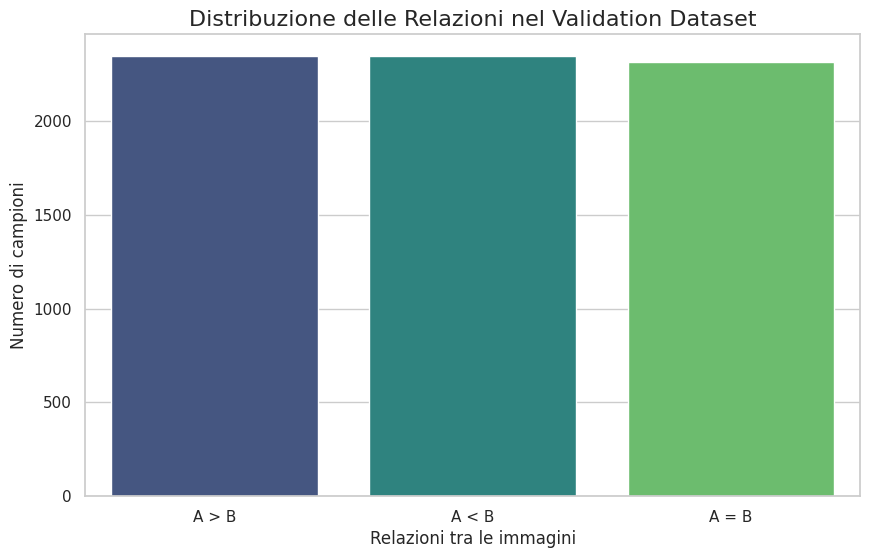

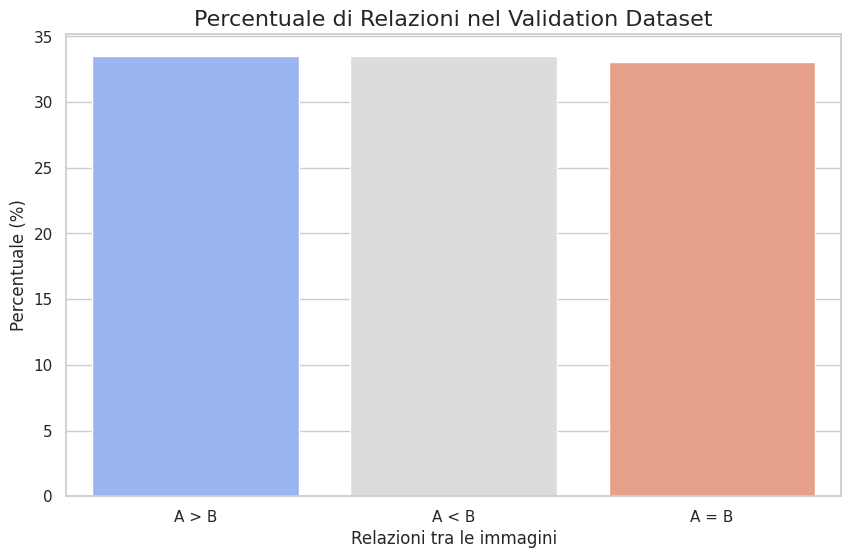

In [6]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [7]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [8]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [41]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [42]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

images dtype: torch.float32, labels dtype: torch.int64


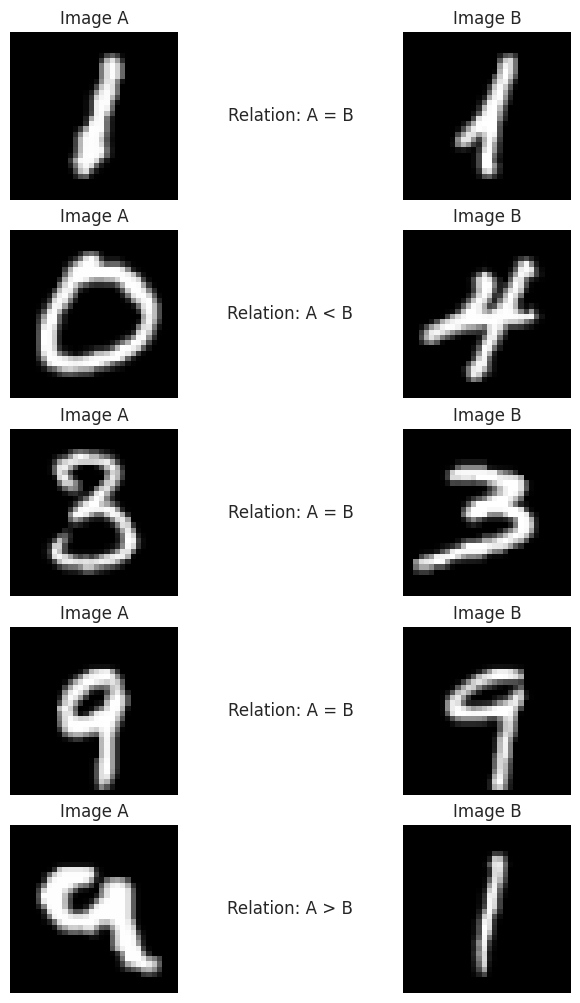

In [43]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [44]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [45]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.6229: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]


Validating


Loss: 0.8110: 100%|██████████| 55/55 [00:00<00:00, 67.30it/s]


Epoch #1 train loss: 0.901 train accuracy: 58.11
Epoch #1 validation loss: 0.811 validation accuracy: 68.80
Learning rate actual:  0.0001
Took 0.236 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.7085: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]


Validating


Loss: 0.7684: 100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Epoch #2 train loss: 0.696 train accuracy: 70.53
Epoch #2 validation loss: 0.768 validation accuracy: 72.41
Learning rate actual:  0.0001
Took 0.255 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.6419: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]


Validating


Loss: 0.7272: 100%|██████████| 55/55 [00:01<00:00, 50.90it/s]


Epoch #3 train loss: 0.641 train accuracy: 73.12
Epoch #3 validation loss: 0.727 validation accuracy: 73.98
Learning rate actual:  0.0001
Took 0.358 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.5812: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]


Validating


Loss: 0.7133: 100%|██████████| 55/55 [00:00<00:00, 61.36it/s]


Epoch #4 train loss: 0.606 train accuracy: 74.66
Epoch #4 validation loss: 0.713 validation accuracy: 76.47
Learning rate actual:  0.0001
Took 0.301 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.5452: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]


Validating


Loss: 0.6776: 100%|██████████| 55/55 [00:00<00:00, 71.27it/s]


Epoch #5 train loss: 0.579 train accuracy: 76.19
Epoch #5 validation loss: 0.678 validation accuracy: 77.41
Learning rate actual:  0.0001
Took 0.289 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.5383: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]


Validating


Loss: 0.6511: 100%|██████████| 55/55 [00:01<00:00, 48.27it/s]


Epoch #6 train loss: 0.555 train accuracy: 77.37
Epoch #6 validation loss: 0.651 validation accuracy: 77.84
Learning rate actual:  0.0001
Took 0.306 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.4514: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]


Validating


Loss: 0.6475: 100%|██████████| 55/55 [00:01<00:00, 49.34it/s]


Epoch #7 train loss: 0.534 train accuracy: 78.36
Epoch #7 validation loss: 0.648 validation accuracy: 78.73
Learning rate actual:  0.0001
Took 0.293 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.5441: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]


Validating


Loss: 0.6588: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s]


Epoch #8 train loss: 0.516 train accuracy: 79.28
Epoch #8 validation loss: 0.659 validation accuracy: 79.85
Learning rate actual:  0.0001
Took 0.290 minutes for epoch 8
No improvement for 1 epoch(s).
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.5661: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]


Validating


Loss: 0.6286: 100%|██████████| 55/55 [00:00<00:00, 59.74it/s]


Epoch #9 train loss: 0.498 train accuracy: 80.11
Epoch #9 validation loss: 0.629 validation accuracy: 80.57
Learning rate actual:  0.0001
Took 0.278 minutes for epoch 9
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.5149: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


Validating


Loss: 0.6753: 100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Epoch #10 train loss: 0.480 train accuracy: 80.83
Epoch #10 validation loss: 0.675 validation accuracy: 80.37
Learning rate actual:  0.0001
Took 0.291 minutes for epoch 10
No improvement for 1 epoch(s).
Checkpoint saved at epoch 10.

EPOCH 11 of 30
Training


Loss: 0.3429: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]


Validating


Loss: 0.6243: 100%|██████████| 55/55 [00:00<00:00, 64.66it/s]


Epoch #11 train loss: 0.466 train accuracy: 81.38
Epoch #11 validation loss: 0.624 validation accuracy: 81.48
Learning rate actual:  0.0001
Took 0.287 minutes for epoch 11
Checkpoint saved at epoch 11.

EPOCH 12 of 30
Training


Loss: 0.3903: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]


Validating


Loss: 0.5898: 100%|██████████| 55/55 [00:00<00:00, 57.31it/s]


Epoch #12 train loss: 0.451 train accuracy: 82.13
Epoch #12 validation loss: 0.590 validation accuracy: 82.03
Learning rate actual:  0.0001
Took 0.296 minutes for epoch 12
Checkpoint saved at epoch 12.

EPOCH 13 of 30
Training


Loss: 0.4071: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]


Validating


Loss: 0.5885: 100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Epoch #13 train loss: 0.435 train accuracy: 82.91
Epoch #13 validation loss: 0.589 validation accuracy: 82.65
Learning rate actual:  0.0001
Took 0.311 minutes for epoch 13
Checkpoint saved at epoch 13.

EPOCH 14 of 30
Training


Loss: 0.3092: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]


Validating


Loss: 0.6200: 100%|██████████| 55/55 [00:01<00:00, 46.17it/s]


Epoch #14 train loss: 0.423 train accuracy: 83.36
Epoch #14 validation loss: 0.620 validation accuracy: 82.73
Learning rate actual:  0.0001
Took 0.316 minutes for epoch 14
No improvement for 1 epoch(s).
Checkpoint saved at epoch 14.

EPOCH 15 of 30
Training


Loss: 0.3878: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]


Validating


Loss: 0.6071: 100%|██████████| 55/55 [00:01<00:00, 44.94it/s]


Epoch #15 train loss: 0.411 train accuracy: 83.89
Epoch #15 validation loss: 0.607 validation accuracy: 83.68
Learning rate actual:  0.0001
Took 0.315 minutes for epoch 15
No improvement for 2 epoch(s).
Checkpoint saved at epoch 15.

EPOCH 16 of 30
Training


Loss: 0.4617: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]


Validating


Loss: 0.5501: 100%|██████████| 55/55 [00:01<00:00, 50.98it/s]


Epoch #16 train loss: 0.398 train accuracy: 84.54
Epoch #16 validation loss: 0.550 validation accuracy: 84.55
Learning rate actual:  0.0001
Took 0.316 minutes for epoch 16
Checkpoint saved at epoch 16.

EPOCH 17 of 30
Training


Loss: 0.3543: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]


Validating


Loss: 0.5698: 100%|██████████| 55/55 [00:01<00:00, 51.93it/s]


Epoch #17 train loss: 0.386 train accuracy: 85.06
Epoch #17 validation loss: 0.570 validation accuracy: 85.01
Learning rate actual:  0.0001
Took 0.300 minutes for epoch 17
No improvement for 1 epoch(s).
Checkpoint saved at epoch 17.

EPOCH 18 of 30
Training


Loss: 0.3870: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]


Validating


Loss: 0.5409: 100%|██████████| 55/55 [00:00<00:00, 56.25it/s]


Epoch #18 train loss: 0.375 train accuracy: 85.53
Epoch #18 validation loss: 0.541 validation accuracy: 85.68
Learning rate actual:  0.0001
Took 0.307 minutes for epoch 18
Checkpoint saved at epoch 18.

EPOCH 19 of 30
Training


Loss: 0.3862: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


Validating


Loss: 0.5512: 100%|██████████| 55/55 [00:01<00:00, 45.60it/s]


Epoch #19 train loss: 0.366 train accuracy: 85.78
Epoch #19 validation loss: 0.551 validation accuracy: 85.66
Learning rate actual:  0.0001
Took 0.298 minutes for epoch 19
No improvement for 1 epoch(s).
Checkpoint saved at epoch 19.

EPOCH 20 of 30
Training


Loss: 0.3263: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]


Validating


Loss: 0.5287: 100%|██████████| 55/55 [00:01<00:00, 51.66it/s]


Epoch #20 train loss: 0.356 train accuracy: 86.37
Epoch #20 validation loss: 0.529 validation accuracy: 85.80
Learning rate actual:  0.0001
Took 0.315 minutes for epoch 20
Checkpoint saved at epoch 20.

EPOCH 21 of 30
Training


Loss: 0.3132: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]


Validating


Loss: 0.5492: 100%|██████████| 55/55 [00:00<00:00, 55.84it/s]


Epoch #21 train loss: 0.346 train accuracy: 86.70
Epoch #21 validation loss: 0.549 validation accuracy: 86.33
Learning rate actual:  0.0001
Took 0.325 minutes for epoch 21
No improvement for 1 epoch(s).
Checkpoint saved at epoch 21.

EPOCH 22 of 30
Training


Loss: 0.3930: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]


Validating


Loss: 0.5136: 100%|██████████| 55/55 [00:01<00:00, 50.03it/s]


Epoch #22 train loss: 0.339 train accuracy: 86.94
Epoch #22 validation loss: 0.514 validation accuracy: 86.66
Learning rate actual:  0.0001
Took 0.324 minutes for epoch 22
Checkpoint saved at epoch 22.

EPOCH 23 of 30
Training


Loss: 0.2697: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


Validating


Loss: 0.5161: 100%|██████████| 55/55 [00:01<00:00, 44.84it/s]


Epoch #23 train loss: 0.329 train accuracy: 87.50
Epoch #23 validation loss: 0.516 validation accuracy: 87.04
Learning rate actual:  0.0001
Took 0.333 minutes for epoch 23
No improvement for 1 epoch(s).
Checkpoint saved at epoch 23.

EPOCH 24 of 30
Training


Loss: 0.4819: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]


Validating


Loss: 0.4715: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s]


Epoch #24 train loss: 0.322 train accuracy: 87.73
Epoch #24 validation loss: 0.471 validation accuracy: 86.50
Learning rate actual:  0.0001
Took 0.306 minutes for epoch 24
Checkpoint saved at epoch 24.

EPOCH 25 of 30
Training


Loss: 0.2903: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]


Validating


Loss: 0.5021: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s]


Epoch #25 train loss: 0.313 train accuracy: 88.15
Epoch #25 validation loss: 0.502 validation accuracy: 87.51
Learning rate actual:  0.0001
Took 0.285 minutes for epoch 25
No improvement for 1 epoch(s).
Checkpoint saved at epoch 25.

EPOCH 26 of 30
Training


Loss: 0.2830: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]


Validating


Loss: 0.5008: 100%|██████████| 55/55 [00:00<00:00, 57.26it/s]


Epoch #26 train loss: 0.306 train accuracy: 88.36
Epoch #26 validation loss: 0.501 validation accuracy: 87.47
Learning rate actual:  0.0001
Took 0.309 minutes for epoch 26
No improvement for 2 epoch(s).
Checkpoint saved at epoch 26.

EPOCH 27 of 30
Training


Loss: 0.3442: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]


Validating


Loss: 0.4923: 100%|██████████| 55/55 [00:01<00:00, 54.00it/s]


Epoch #27 train loss: 0.299 train accuracy: 88.78
Epoch #27 validation loss: 0.492 validation accuracy: 87.57
Learning rate actual:  0.0001
Took 0.313 minutes for epoch 27
No improvement for 3 epoch(s).
Checkpoint saved at epoch 27.

EPOCH 28 of 30
Training


Loss: 0.2027: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]


Validating


Loss: 0.4900: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s]


Epoch #28 train loss: 0.294 train accuracy: 89.00
Epoch #28 validation loss: 0.490 validation accuracy: 87.36
Learning rate actual:  0.0001
Took 0.295 minutes for epoch 28
No improvement for 4 epoch(s).
Checkpoint saved at epoch 28.

EPOCH 29 of 30
Training


Loss: 0.2529: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]


Validating


Loss: 0.4423: 100%|██████████| 55/55 [00:01<00:00, 53.60it/s]


Epoch #29 train loss: 0.285 train accuracy: 89.30
Epoch #29 validation loss: 0.442 validation accuracy: 88.21
Learning rate actual:  0.0001
Took 0.287 minutes for epoch 29
Checkpoint saved at epoch 29.

EPOCH 30 of 30
Training


Loss: 0.3214: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]


Validating


Loss: 0.4407: 100%|██████████| 55/55 [00:00<00:00, 68.95it/s]


Epoch #30 train loss: 0.278 train accuracy: 89.68
Epoch #30 validation loss: 0.441 validation accuracy: 88.67
Learning rate actual:  0.0001
Took 0.275 minutes for epoch 30
Checkpoint saved at epoch 30.
Validating


Loss: 0.2522: 100%|██████████| 24/24 [00:00<00:00, 59.57it/s]


Test loss: 0.252 Test accuracy: 88.07


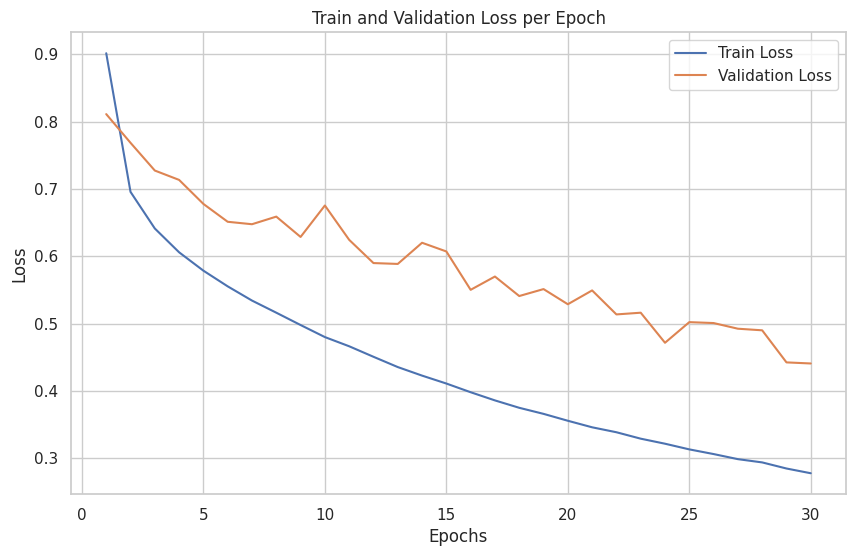

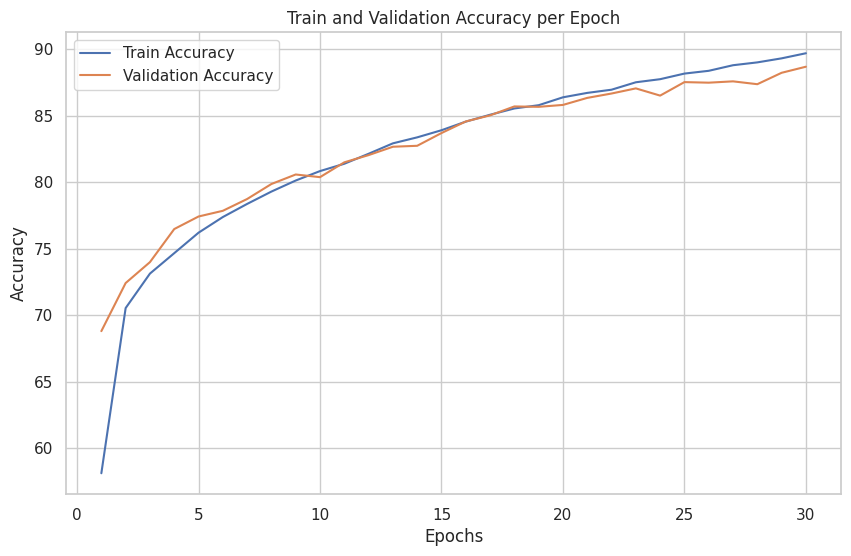

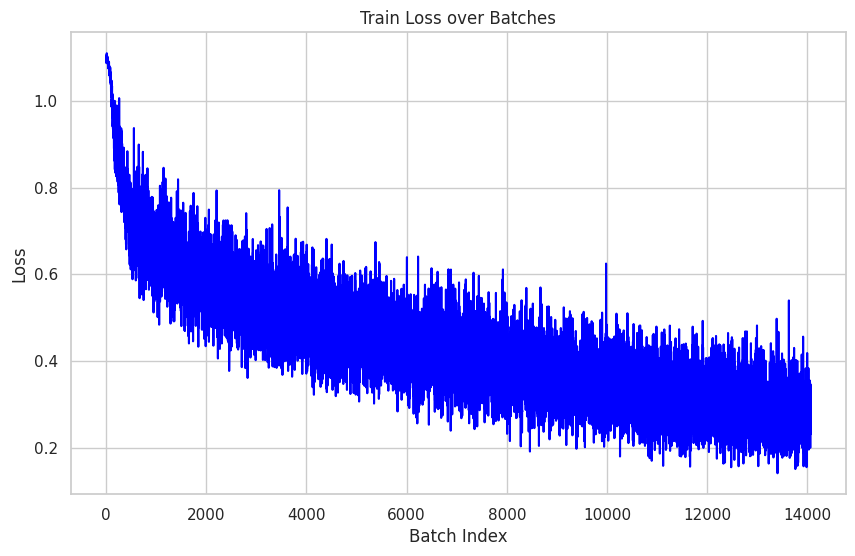

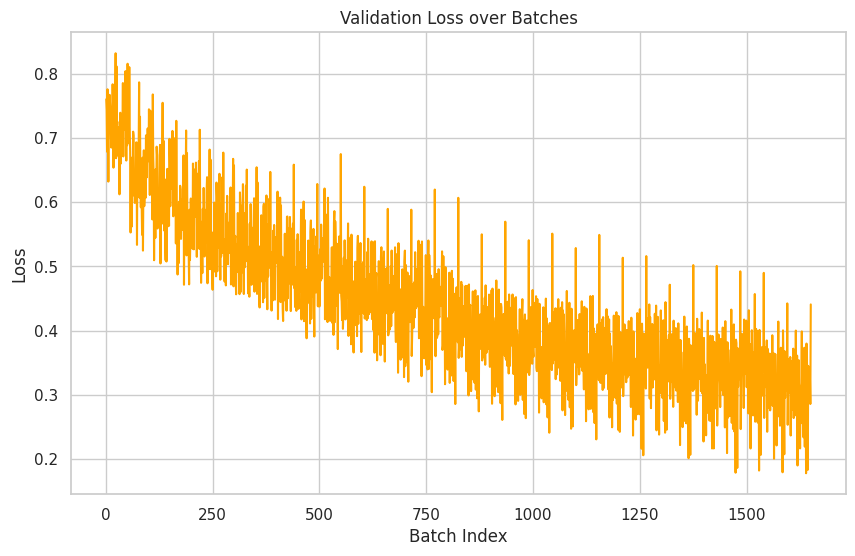

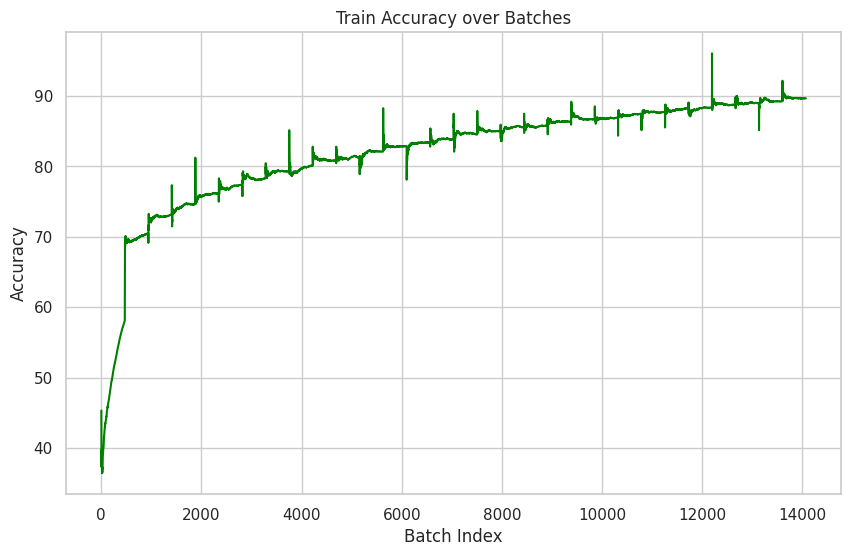

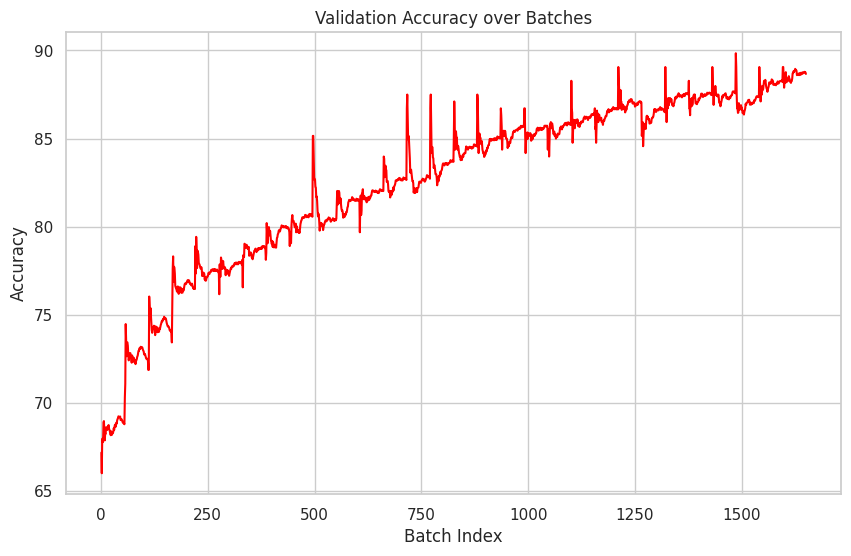

In [46]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

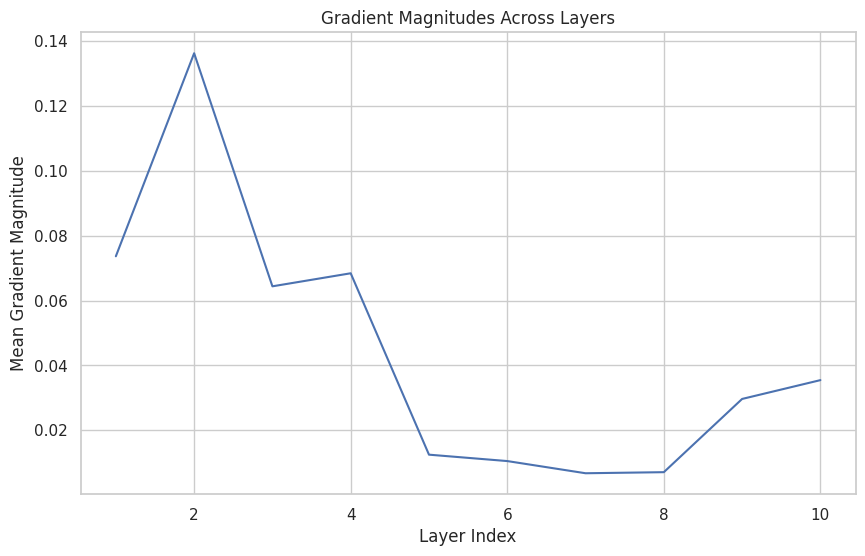

In [47]:
utils.plot_gradient(model)

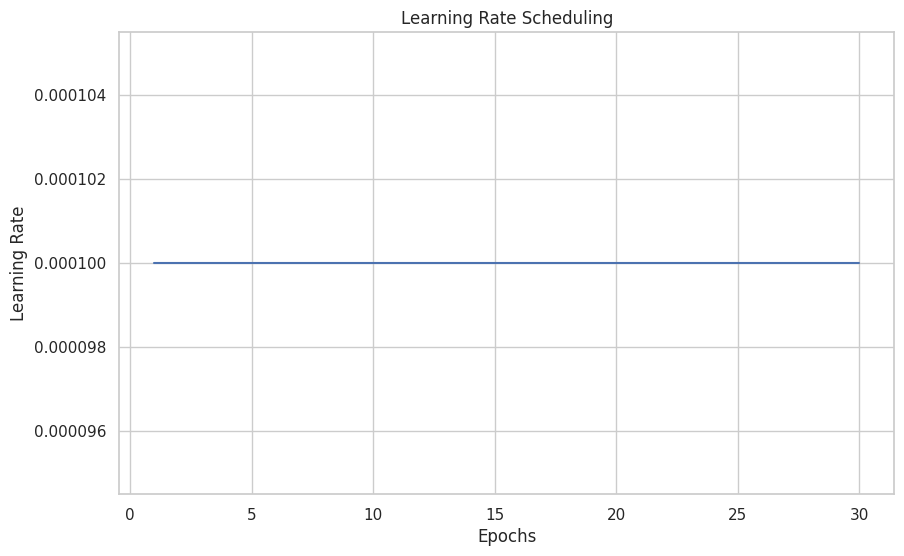

In [48]:
utils.plot_lr_scheduler(lr_history)

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions', utils.show_incorrect_predictions(model, validation_loader, device, num_images=10))
#show_incorrect_predictions(model, validation_loader, num_images=5)

793 previsioni errate trovate.


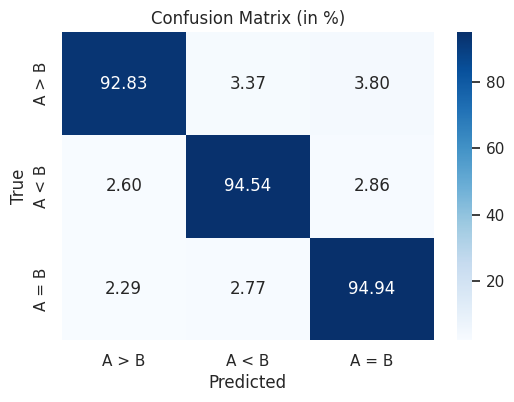

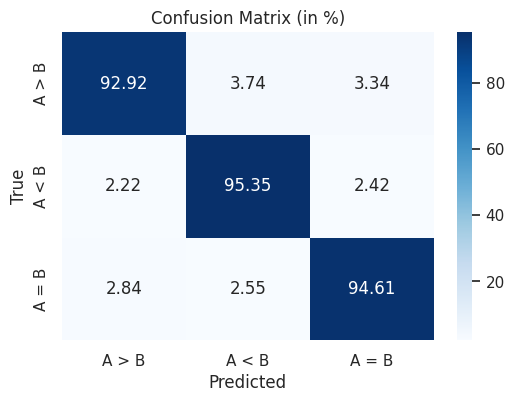

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(model, validation_loader, device))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(model, test_loader, device))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.95      0.93      0.94       989
       A < B       0.94      0.95      0.95       990
       A = B       0.94      0.95      0.95      1021

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32.ipynb')


Notebook saved as run32x32_BS=128_LR=0.001_EPOCHS=30_AUG=False_TRA=False_OPT=ADAM.ipynb


In [ ]:
writer.close()